# 3.5: 量子线路实现监督性学习

## Applying a Gate on States in a Batch

In [1]:
from tensor_network.utils import (
    iterable_have_common,
    inverse_permutation,
    check_quantum_gate,
    check_state_tensor,
    unify_tensor_dtypes,
)
import torch
from typing import List
from einops import einsum
from tensor_network.tensor_gates.functional import apply_gate

In [2]:
# |export tensor_gates.functional
def apply_gate_batched(
    *,
    quantum_states: torch.Tensor,
    gate: torch.Tensor,
    target_qubit: int | List[int],
    control_qubit: int | List[int] | None = None,
) -> torch.Tensor:
    """
    Apply a quantum gate to a quantum state tensor. It can also be used to implement controlled gates by specifying control qubits.

    Args:
        quantum_states (torch.Tensor): The batched quantum state tensor with batch dimension at 0
        gate (torch.Tensor): The quantum gate tensor, not batched.
        target_qubit (int | List[int]): The target qubit(s) to apply the gate to.
        control_qubit (int | List[int] | None): The control qubit(s) for the gate. If None, no control qubits are used.
    Returns:
        torch.Tensor: The new quantum state tensor after applying the gate.
    """
    check_state_tensor(quantum_states[0])

    # check types
    assert isinstance(target_qubit, (int, list)), "target qubit must be int or list"
    assert control_qubit is None or isinstance(control_qubit, (int, list)), (
        "control_qubit must be int or list"
    )

    # unify types
    if isinstance(target_qubit, int):
        target_qubit = [target_qubit]
    if control_qubit is None:
        control_qubit = []
    elif isinstance(control_qubit, int):
        control_qubit = [control_qubit]
    assert not iterable_have_common(target_qubit, control_qubit), (
        "target qubit and control qubit must not overlap"
    )

    batch_num = quantum_states.shape[0]
    num_qubits = quantum_states.ndim - 1  # because of batch dimension
    num_target_qubit = len(target_qubit)
    num_control_qubit = len(control_qubit)
    assert num_qubits >= num_target_qubit + num_control_qubit, (
        "number of qubits must be greater than or equal to the number of target qubits and control qubits"
    )
    check_quantum_gate(gate, num_target_qubit)

    quantum_states, gate = unify_tensor_dtypes(quantum_states, gate)
    # permute the batch dim to the last dim
    quantum_states = torch.movedim(quantum_states, 0, -1)  # (*qubit_shapes, batch_dim)
    batch_dim_idx = quantum_states.ndim - 1

    # check indices
    for qidx in target_qubit:
        assert 0 <= qidx < num_qubits, f"target qubit index {qidx} out of range"
    for qidx in control_qubit:
        assert 0 <= qidx < num_qubits, f"control qubit index {qidx} out of range"

    if gate.ndim == 2:
        # if in matrix form, reshape to tensor form
        new_shape = [2] * (num_target_qubit * 2)
        gate = gate.reshape(new_shape)

    other_qubits = list(range(num_qubits))
    for qubit_idx in target_qubit:
        other_qubits.remove(qubit_idx)
    for qubit_idx in control_qubit:
        other_qubits.remove(qubit_idx)

    num_other_qubits = len(other_qubits)
    permute_qubit_dims = target_qubit + other_qubits + control_qubit + [batch_dim_idx]
    state = torch.permute(quantum_states, permute_qubit_dims)
    state_shape = (
        state.shape
    )  # (*target_qubit_shapes, *other_qubit_shapes, *control_qubit_shapes, batch_dim)
    # Flatten the state tensor, so that the shape is (target_qubit_shapes, other_qubit_shapes, -1, batch_dim)
    new_shape = [2] * (num_target_qubit + num_other_qubits) + [-1, batch_num]
    state = state.reshape(new_shape)
    # only when control qubits are 11111... the gate is applied
    unaffected_state = state[
        ..., :-1, :
    ]  # (*target_qubit_shapes, *other_qubit_shapes, flattened_dim-1, batch_dim)
    state_to_apply_gate = state[
        ..., -1, :
    ]  # (*target_qubit_shapes, *other_qubit_shapes, batch_dim)
    # apply gate
    batch_dim_name = "batch"
    target_qubit_names = [f"t{i}" for i in target_qubit]
    other_qubit_names = [f"o{i}" for i in other_qubits]
    gate_output_qubit_names = [f"g{i}" for i in target_qubit]
    einsum_str = "{gate_dims}, {state_dims} -> {output_dims}".format(
        gate_dims=" ".join(gate_output_qubit_names + target_qubit_names),
        state_dims=" ".join(target_qubit_names + other_qubit_names + [batch_dim_name]),
        output_dims=" ".join(gate_output_qubit_names + other_qubit_names + [batch_dim_name]),
    )
    new_state = einsum(gate, state_to_apply_gate, einsum_str)
    new_state = new_state.unsqueeze(-2)  # (*target_qubit_shapes, *other_qubit_shapes, 1, batch_dim)

    final_state = torch.cat(
        [unaffected_state, new_state], dim=-2
    )  # (*target_qubit_shapes, *other_qubit_shapes, flattened_dim)
    final_state = final_state.reshape(
        state_shape
    )  # (*target_qubit_shapes, *other_qubit_shapes, *control_qubit_shapes, batch_dim)

    # inverse the previous permutations
    inverse_permute_qubit_dims = inverse_permutation(permute_qubit_dims)
    final_state = final_state.permute(inverse_permute_qubit_dims)  # (*qubit_shapes, batch_dim)
    final_state = torch.movedim(final_state, -1, 0)  # (batch_dim, *qubit_shapes)
    return final_state


def apply_gate_nonbatched(
    *,
    quantum_state: torch.Tensor,
    gate: torch.Tensor,
    target_qubit: int | List[int],
    control_qubit: int | List[int] | None = None,
) -> torch.Tensor:
    """
    Apply a quantum gate to a quantum state tensor. It can also be used to implement controlled gates by specifying control qubits.

    Same as `apply_gate`, but use `apply_gate_batched` under the hood.

    Args:
        quantum_state (torch.Tensor): The quantum state tensor.
        gate (torch.Tensor): The quantum gate tensor, not batched.
        target_qubit (int | List[int]): The target qubit(s) to apply the gate to.
        control_qubit (int | List[int] | None): The control qubit(s) for the gate. If None, no control qubits are used.
    Returns:
        torch.Tensor: The new quantum state tensor after applying the gate.
    """
    quantum_state = quantum_state.unsqueeze(0)  # add batch dimension
    return apply_gate_batched(
        quantum_states=quantum_state,
        gate=gate,
        target_qubit=target_qubit,
        control_qubit=control_qubit,
    ).squeeze(0)


# need this to wrap apply_gate because of vmap's specification on kwargs
def __apply_gate_for_vmap(
    state: torch.Tensor,
    gate: torch.Tensor,
    *,
    target_qubit: int | List[int],
    control_qubit: int | List[int] | None = None,
):
    return apply_gate(
        quantum_state=state, gate=gate, target_qubit=target_qubit, control_qubit=control_qubit
    )


apply_gate_batched_with_vmap = torch.vmap(__apply_gate_for_vmap, in_dims=(0, None))

### Test

In [3]:
# set up importing for ref code
from tensor_network import setup_ref_code_import
from Library.QuantumState import TensorPureState
from copy import deepcopy

From setup_ref_code_import:
  Added reference_code_path='/Users/zhiqiu/offline_code/personal/tensor_network/reference_code' to sys.path.
  You can import the reference code now.


In [4]:
# initialize a quantum state of 4 qubits
state = TensorPureState(nq=4, dtype=torch.complex128)

# initialize a random quantum gate of 1 qubit
gate1 = torch.randn(2, 2, dtype=torch.complex128)
# initialize a random quantum gate of 2 qubits
gate2_mat = torch.randn(4, 4, dtype=torch.complex128)
gate2_tensor = gate2_mat.reshape(2, 2, 2, 2)
# initialize a random quantum gate of 3 qubits
gate3_mat = torch.randn(8, 8, dtype=torch.complex128)
gate3_tensor = gate3_mat.reshape(2, 2, 2, 2, 2, 2)
# initialize a random quantum gate of 4 qubits
gate4_mat = torch.randn(16, 16, dtype=torch.complex128)
gate4_tensor = gate4_mat.reshape(2, 2, 2, 2, 2, 2, 2, 2)

# tests
for i, (gate_mat, gate_tensor) in enumerate(
    [
        (gate1, gate1),
        (gate2_mat, gate2_tensor),
        (gate3_mat, gate3_tensor),
        (gate4_mat, gate4_tensor),
    ]
):
    qubit_num = i + 1
    s = deepcopy(state)
    t = s.tensor.clone()
    target_qubit = list(range(qubit_num))
    s.act_single_gate(gate=gate_tensor, pos=target_qubit)
    result_ref = s.tensor
    result_mat = apply_gate(quantum_state=t, gate=gate_mat, target_qubit=target_qubit)
    result_tensor = apply_gate(quantum_state=t, gate=gate_tensor, target_qubit=target_qubit)

    result_batched_mat = apply_gate_batched(
        quantum_states=t.unsqueeze(0),
        gate=gate_mat,
        target_qubit=target_qubit,
    ).squeeze(0)
    result_batched_tensor = apply_gate_batched(
        quantum_states=t.unsqueeze(0),
        gate=gate_tensor,
        target_qubit=target_qubit,
    ).squeeze(0)
    result_batched_mat_vmap = apply_gate_batched_with_vmap(
        t.unsqueeze(0),
        gate_mat,
        target_qubit=target_qubit,
    ).squeeze(0)
    result_batched_tensor_vmap = apply_gate_batched_with_vmap(
        t.unsqueeze(0),
        gate_tensor,
        target_qubit=target_qubit,
    ).squeeze(0)

    assert torch.allclose(result_batched_mat, result_ref), (
        f"result: {result_batched_mat}, result_ref: {result_ref}"
    )
    assert torch.allclose(result_mat, result_ref), f"result: {result_mat}, result_ref: {result_ref}"
    assert torch.allclose(result_batched_mat_vmap, result_ref), (
        f"result: {result_batched_mat_vmap}, result_ref: {result_ref}"
    )

    assert torch.allclose(result_tensor, result_ref), (
        f"result: {result_tensor}, result_ref: {result_ref}"
    )
    assert torch.allclose(result_batched_tensor, result_ref), (
        f"result: {result_batched_tensor}, result_ref: {result_ref}"
    )
    assert torch.allclose(result_batched_tensor_vmap, result_ref), (
        f"result: {result_batched_tensor_vmap}, result_ref: {result_ref}"
    )

### Comparison: batch operation vs vmap

In [5]:
from time import time
from matplotlib import pyplot as plt

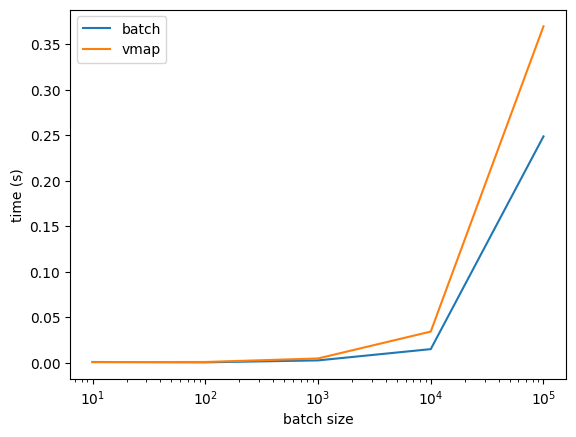

In [6]:
num_qubits = 6
batch_sizes = [10, 100, 1000, 10000, 100000]
batch = 1000

# initialize a random quantum gate of 1 qubit
gate1 = torch.randn(2, 2, dtype=torch.complex128)
# initialize a random quantum gate of 2 qubits
gate2_mat = torch.randn(4, 4, dtype=torch.complex128)
gate2_tensor = gate2_mat.reshape(2, 2, 2, 2)
# initialize a random quantum gate of 3 qubits
gate3_mat = torch.randn(8, 8, dtype=torch.complex128)
gate3_tensor = gate3_mat.reshape(2, 2, 2, 2, 2, 2)
# initialize a random quantum gate of 4 qubits
gate4_mat = torch.randn(16, 16, dtype=torch.complex128)
gate4_tensor = gate4_mat.reshape(2, 2, 2, 2, 2, 2, 2, 2)

gates = [
    gate1,
    gate2_tensor,
    gate3_tensor,
    gate4_tensor,
]

batch_times = []
vmap_times = []

for batch in batch_sizes:
    states = torch.randn(*([batch] + [2] * num_qubits), dtype=torch.complex64)

    start = time()

    for i, gate in enumerate(gates):
        qubit_num = i + 1
        target_qubit = list(range(qubit_num))
        apply_gate_batched(
            quantum_states=states,
            gate=gate,
            target_qubit=target_qubit,
        )

    end = time()
    batch_times.append(end - start)

    start = time()
    for i, gate in enumerate(gates):
        qubit_num = i + 1
        target_qubit = list(range(qubit_num))
        apply_gate_batched_with_vmap(
            states,
            gate,
            target_qubit=target_qubit,
        )
    end = time()
    vmap_times.append(end - start)


plt.plot(batch_sizes, batch_times, label="batch")
plt.plot(batch_sizes, vmap_times, label="vmap")
plt.xlabel("batch size")
plt.ylabel("time (s)")
plt.legend()
plt.xscale("log")

## Iris Classification

### ADQCNet

In [7]:
# |export networks.adqc
from torch import nn
from typing import Literal, Tuple, List
from tensor_network.tensor_gates.modules import ADQCGate


class ADQCNet(nn.Module):
    """
    A simple ADQC network.
    """

    def __init__(
        self,
        *,
        num_qubits: int,
        num_layers: int,
        gate_pattern: Literal["brick", "stair"],
        identity_init: bool = False,
        double_precision: bool = False,
    ):
        """
        Args:
            num_qubits (int): The number of qubits in the network.
            num_layers (int): The number of layers in the network.
            gate_pattern (Literal["brick", "stair"]): The pattern of the gates in the network.
            identity_init (bool): Whether to initialize the gates with identity matrix + random noise.
            double_precision (bool): Whether to use double precision for the gates.
        """
        super().__init__()
        target_positions = self.calc_gate_target_qubit_positions(gate_pattern, num_qubits)
        gates = []
        self.num_qubits = num_qubits

        for layer_idx in range(num_layers):
            for target_qubit_indices in target_positions:
                gate = ADQCGate(
                    batched_input=True,
                    target_qubit=list(target_qubit_indices),
                    gate_name=f"ADQC-{layer_idx}-{target_qubit_indices}",
                    identity_init=identity_init,
                    double_precision=double_precision,
                )
                gates.append(gate)

        self.net = nn.Sequential(*gates)

    def forward(self, qubit_states: torch.Tensor) -> torch.Tensor:
        assert len(qubit_states.shape) == self.num_qubits + 1, (
            f"qubit_states must have {self.num_qubits + 1} dimensions, but got {len(qubit_states.shape)}"
        )
        return self.net(qubit_states)

    @staticmethod
    def calc_gate_target_qubit_positions(
        gate_pattern: Literal["brick", "stair"], num_qubits: int
    ) -> List[Tuple[int, int]]:
        assert gate_pattern in ["brick", "stair"], (
            f"""gate_pattern must be either "brick" or "stair", but got {gate_pattern}"""
        )
        assert num_qubits > 0, "number of qubits must be greater than 0"
        target_positions = []
        if gate_pattern == "stair":
            for p in range(num_qubits - 1):
                target_positions.append((p, p + 1))
        else:  # brick
            p = 0
            while p < num_qubits - 1:
                target_positions.append((p, p + 1))
                p += 2
            p = 1
            while p < num_qubits - 1:
                target_positions.append((p, p + 1))
                p += 2
        return target_positions

In [8]:
# simple test

state = torch.randn(2, 2, 2, 2, dtype=torch.complex64)
net = ADQCNet(
    num_qubits=4, num_layers=2, gate_pattern="stair", identity_init=True, double_precision=False
)
with torch.no_grad():
    after = net(state.unsqueeze(0))
    print(after.shape)

torch.Size([1, 2, 2, 2, 2])


### Feature Mapping

In [9]:
# |default_exp feature_mapping
# |export
import torch

In [10]:
# |export


def cossin_feature_map(samples: torch.Tensor, theta: float = 1.0) -> torch.Tensor:
    """
    Apply cossin feature mapping for qubit systems (d=2).

    See: https://proceedings.neurips.cc/paper/2016/hash/5314b9674c86e3f9d1ba25ef9bb32895-Abstract.html

    And also see https://www.perplexity.ai/search/do-you-know-the-cossin-feature-PidGvE9TTZSx9NaxAi23Gg

    Args:
        samples: Input tensor of shape (batch_size, feature_num)
        theta: Angle parameter (default: 1.0)

    Returns:
        Transformed features of shape (batch_size, feature_num, 2)
    """
    # Ensure samples is a 2D tensor
    if samples.ndimension() == 1:
        samples = samples.unsqueeze(0)  # Add batch dimension if missing

    # Calculate the cosine and sine components
    angle = samples * (theta * torch.pi)
    cos_features = torch.cos(angle)
    sin_features = torch.sin(angle)

    # Stack the features along a new dimension
    # Shape becomes (batch_size, feature_num, 2)
    stacked_features = torch.stack([cos_features, sin_features], dim=-1)

    return stacked_features

### Training

#### Utils

In [11]:
# |export tensor_utils
from typing import Tuple


def normalize_tensor(tensor: torch.Tensor, dim: int | None = None) -> torch.Tensor:
    """
    Normalize a tensor to the range [0, 1].

    Args:
        tensor (torch.Tensor): The tensor to normalize.
        dim (int | None, optional): The dimension along which to normalize.
            If None, normalizes across the entire tensor. Defaults to None.

    Returns:
        torch.Tensor: The normalized tensor with values in the range [0, 1].
    """
    if dim is None:
        min_val = torch.min(tensor)
        max_val = torch.max(tensor)
    else:
        min_val = torch.min(tensor, dim, keepdim=True).values
        max_val = torch.max(tensor, dim, keepdim=True).values
    return (tensor - min_val) / (max_val - min_val)


def rescale_tensor(
    tensor: torch.Tensor, min_val: float, max_val: float, dim: None | int | Tuple[int, ...] = None
) -> torch.Tensor:
    """
    Rescale a tensor to a specified range.

    Args:
        tensor (torch.Tensor): The tensor to rescale.
        min_val (float): The minimum value of the target range.
        max_val (float): The maximum value of the target range.
        dim (None | int | Tuple[int, ...], optional): The dimension(s) along which to rescale.
            If None, rescales across the entire tensor. Defaults to None.

    Returns:
        torch.Tensor: The rescaled tensor with values in the range [min_val, max_val].
    """

    normalized_tensor = normalize_tensor(tensor, dim)
    return normalized_tensor * (max_val - min_val) + min_val

In [12]:
# |export utils
def split_classification_dataset(
    data: torch.Tensor, targets: torch.Tensor, ratio: float, shuffle: bool = True
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Split the dataset into training and testing sets.

    Args:
        data (torch.Tensor): The data tensor.
        target (torch.Tensor): The target tensor.
        ratio (float): The ratio of the training set.
        shuffle (bool): Whether to shuffle the data.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: The training samples, training labels, testing samples, testing labels.
    """
    assert targets.dtype in [torch.int, torch.long], "target must be an integer tensor"
    assert 1.0 > ratio > 0.0, "ratio must be between 0 and 1"
    num_classes = torch.max(targets) + 1
    num_samples = data.shape[0]
    assert num_samples == targets.shape[0], "data and target must have the same number of samples"
    train_samples = []
    train_labels = []
    test_samples = []
    test_labels = []
    for class_idx in range(num_classes):
        sample_class_i = data[targets == class_idx]
        num_samples_class_i = sample_class_i.shape[0]
        num_train = int(num_samples_class_i * (1 - ratio))
        if shuffle:
            shuffle_idx = torch.randperm(num_samples_class_i)
            shuffled_sample_class_i = sample_class_i[shuffle_idx]
            train_sample = shuffled_sample_class_i[:num_train]
            train_samples.append(train_sample)
            test_sample = shuffled_sample_class_i[num_train:]
            test_samples.append(test_sample)

            train_labels.append(
                torch.full((train_sample.shape[0],), class_idx, dtype=targets.dtype)
            )
            test_labels.append(torch.full((test_sample.shape[0],), class_idx, dtype=targets.dtype))
        else:
            train_sample = sample_class_i[:num_train]
            train_samples.append(train_sample)
            test_sample = sample_class_i[num_train:]
            test_samples.append(test_sample)
            train_labels.append(
                torch.full((train_sample.shape[0],), class_idx, dtype=targets.dtype)
            )
            test_labels.append(torch.full((test_sample.shape[0],), class_idx, dtype=targets.dtype))

    train_samples = torch.cat(train_samples, dim=0)
    train_labels = torch.cat(train_labels, dim=0)
    test_samples = torch.cat(test_samples, dim=0)
    test_labels = torch.cat(test_labels, dim=0)
    return train_samples, train_labels, test_samples, test_labels

In [13]:
from einops import einsum


def sample_feature_to_qubit_tensor(samples: torch.Tensor) -> torch.Tensor:
    """
    Converts a tensor of sample features to a tensor suitable for qubit operations.

    This function takes a tensor of shape (batch_size, 4, 2) representing 4 features each with 2 qubits.
    It cross product the features to produce quantum state tensor of shape (batch_size, 2, 2, 2, 2)

    Parameters:
    - samples (torch.Tensor): The input tensor of shape (batch_size, 4, 2) representing the sample features.

    Returns:
    - torch.Tensor: A tensor of shape (batch_size, 2, 2, 2, 2) representing the qubit state.
    """

    # samples: (batch_size, 4, 2)
    assert samples.ndimension() == 3
    assert samples.shape[1] == 4  # 4 features
    assert samples.shape[2] == 2  # 1 qubit per feature
    feature0 = samples[:, 0, :]  # (batch_size, 2)
    feature1 = samples[:, 1, :]  # (batch_size, 2)
    feature2 = samples[:, 2, :]  # (batch_size, 2)
    feature3 = samples[:, 3, :]  # (batch_size, 2)
    einsum_str = "b q0, b q1, b q2, b q3 -> b q0 q1 q2 q3"  # (batch_size, 2, 2, 2, 2)
    return einsum(feature0, feature1, feature2, feature3, einsum_str)

#### Hyper-parameters

In [14]:
# Training parameters
lr = 1e-3
batch_size = 10
num_epochs = 1000
test_set_ratio = 0.2
device = torch.cpu

# Network parameters
adqc_net_depth = 4
adqc_net_gate_pattern = "stair"
adqc_net_identity_init = True
adqc_net_double_precision = False

# Data parameters
num_classes = 3

In [15]:
from torch.utils.data import TensorDataset, DataLoader
from tensor_network.utils import load_iris
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [16]:
data, targets = load_iris(force_single_precision=True)
data = normalize_tensor(data, dim=0)

train_samples, train_labels, test_samples, test_labels = split_classification_dataset(
    data, targets, test_set_ratio, shuffle=True
)

training_dataset = TensorDataset(train_samples, train_labels)
test_dataset = TensorDataset(test_samples, test_labels)

training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# |export networks.adqc
from numpy import ceil, log2


def probabilities_adqc_classifier(qubit_states: torch.Tensor, num_classes: int):
    """
    Compute normalized class probabilities from qubit states for a quantum classifier.

    Args:
        qubit_states (torch.Tensor): Tensor containing the quantum states. The tensor should have
                                     an odd number of dimensions with the first dimension being
                                     the batch size.
        num_classes (int): Number of classes for classification. Must be >= 2.

    Returns:
        torch.Tensor: Normalized probabilities for each class. Shape: (batch_size, num_classes)

    Notes:
        - The function takes the last log2(num_classes) qubits and uses their measured
          probabilities as the classifier's output.
        - Only the first `num_classes` base states are used for classification.
        - Probabilities are normalized to sum to 1 for each sample.
    """
    DELTA = 1e-10
    assert qubit_states.ndimension() % 2 == 1
    assert num_classes >= 2, "number of classes must be greater than 2"
    num_qubit_required = int(ceil(log2(num_classes)))
    assert qubit_states.ndimension() >= num_qubit_required + 1
    batch_size = qubit_states.shape[0]
    # take the last `num_qubit_required` qubits and use their measured probabilities as the classifier's output
    qubit_states = qubit_states.reshape(batch_size, -1, 2**num_qubit_required)
    # use the first `num_classes` base states of the `num_qubit_required` qubits as the classifier's output
    substates = qubit_states[:, :, :num_classes]  # (batch_size, 2**other_qubit_num, num_classes)
    probabilities = (substates * substates.conj()).real
    probabilities_of_classes = torch.sum(probabilities, dim=1)  # (batch_size, num_classes)
    prob_norm = torch.sum(probabilities_of_classes, dim=1, keepdim=True) + DELTA  # (batch_size, 1)
    normalized_class_probabilities = probabilities_of_classes / prob_norm
    return normalized_class_probabilities

In [18]:
net = ADQCNet(
    num_qubits=4, num_layers=2, gate_pattern="stair", identity_init=True, double_precision=False
)

optimizer = Adam(net.parameters(), lr=lr)

In [19]:
# |export networks.adqc
def calc_accuracy(probabilities: torch.Tensor, targets: torch.Tensor) -> float:
    assert probabilities.ndimension() == 2
    assert targets.ndimension() == 1
    assert probabilities.shape[0] == targets.shape[0]
    predicted_classes = torch.argmax(probabilities, dim=1)
    return (predicted_classes == targets).float().mean().item()

In [20]:
losses = torch.empty(num_epochs, dtype=torch.float32)
accuracies = torch.empty(num_epochs, dtype=torch.float32)

for i in tqdm(range(num_epochs)):
    batch_losses = []
    sample_num = 0
    correct_predictions = 0
    for sample_batch, target_batch in training_loader:
        sample_features = cossin_feature_map(sample_batch)
        states = sample_feature_to_qubit_tensor(sample_features)
        states = net(states)
        classes_probabilities = probabilities_adqc_classifier(states, num_classes)
        loss = F.nll_loss(torch.log(classes_probabilities), target_batch)
        batch_num = sample_batch.shape[0]
        batch_losses.append(loss.detach() * batch_num)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        sample_num += batch_num
        correct_predictions += (
            calc_accuracy(classes_probabilities.detach(), target_batch) * batch_num
        )

    epoch_loss = torch.tensor(batch_losses).sum() / sample_num
    epoch_accuracy = correct_predictions / sample_num
    losses[i] = epoch_loss
    accuracies[i] = epoch_accuracy

  0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
test_batch_accuracy = []
test_sample_num = 0
with torch.no_grad():
    for sample_batch, target_batch in test_loader:
        sample_features = cossin_feature_map(sample_batch)
        states = sample_feature_to_qubit_tensor(sample_features)
        states = net(states)
        classes_probabilities = probabilities_adqc_classifier(states, num_classes)
        test_batch_accuracy.append(
            calc_accuracy(classes_probabilities, target_batch) * sample_batch.shape[0]
        )
        test_sample_num += sample_batch.shape[0]

test_accuracy = torch.tensor(test_batch_accuracy).sum() / test_sample_num
print(f"test accuracy: {test_accuracy}")

test accuracy: 1.0


/var/folders/cg/6l5b95y14c18297sgdjvpcbc0000gn/T/ipykernel_8975/700368716.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


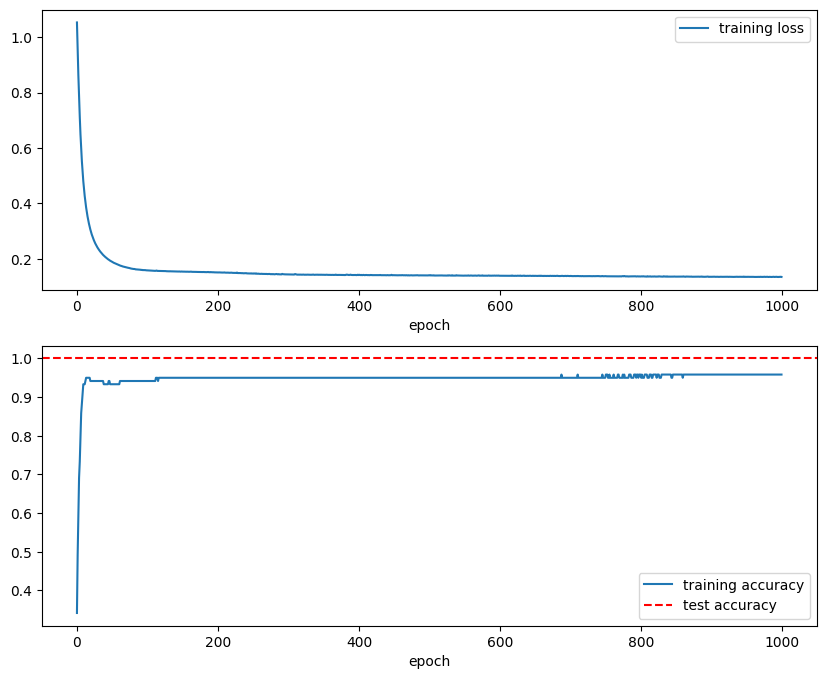

In [22]:
# plot losses and accuracies in two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(losses, label="training loss")
ax1.set_xlabel("epoch")
ax1.legend()
# plot training accuracy and test accuracy
ax2.plot(accuracies, label="training accuracy")
ax2.set_xlabel("epoch")
ax2.legend()
ax2.axhline(test_accuracy, label="test accuracy", color="red", linestyle="--")
ax2.legend()
fig.show()